In [1]:
import seaborn as sns
import numpy as np

from scipy.stats import poisson
import numpy as np

In [2]:
class Poisson(object):
    cache_pmf = {}
    cache_sf = {}
    cache = {}
    MAX_CUTOFF = 25

    @classmethod
    def pmf_series(cls, mu, cutoff):
        assert isinstance(mu, int), "mu should be an integer."
        assert isinstance(cutoff, int), "cutoff should be an integer"

        if (mu, cutoff) not in cls.cache:
            cls._calculate_pmf_series(mu, cutoff)

        return cls.cache[(mu, cutoff)]

    @classmethod
    def _calculate_pmf_series(cls, mu, cutoff):

        if mu not in cls.cache_pmf:
            print("Calculate poisson ...")
            cls.cache_pmf[mu] = poisson.pmf(np.arange(cls.MAX_CUTOFF + 1), mu)
            cls.cache_sf[mu] = poisson.sf(np.arange(cls.MAX_CUTOFF + 1), mu)

        out = np.copy(cls.cache_pmf[mu][:cutoff+1])
        out[-1] += cls.cache_sf[mu][cutoff]

        cls.cache[(mu, cutoff)] = out

In this code, we first define the problem parameters, including the maximum number of bikes at each location, the maximum number of bikes to move between locations, the reward for renting out a bike, the cost of moving a bike between locations, and the discount factor.

We then initialize the value function to zero and run the value iteration algorithm until convergence, which is determined by a specified tolerance threshold.

For each (i,j) state and all possible actions, the code calculates the corresponding Q value using the transition probabilities, reward function, and discount factor. It then selects the action with the maximum Q value for each state and updates the value function accordingly. This process continues until the value function converges to its optimal value.

Finally, the optimal value function is outputted. Note that this code assumes that the Poisson distribution and probability mass function have already been defined and calculated outside of the loop.

Calculate poisson ...
Calculate poisson ...
Calculate poisson ...
193.34904927512352
134.00426086449983
90.45243773749041
67.59779106615537
53.584930617584064
41.72086291128721
32.72010939685788
26.087556138178115
21.778143392699917
18.31805979033311
15.367406347701888
12.861027123616623
10.739286690815788
8.949004145272568
7.44312843375684
6.180206266078585
5.123897292162269
4.242540347244926
3.5087368683560953
2.898934555425967
2.393012044082809
1.973873579670851
1.6270638320038415
1.3404108007533182
1.103701663738775
0.9083935811099764
0.747359290960901
0.6146658513105194
0.5053839897122998
0.4154250710594738
0.3414025532428582
0.2805148621151261
0.23044680201468282
0.18928686930178173
0.1554581156260042
0.12766049026453175
0.1048228615680955
0.08606316780407042
0.07065537333363636
0.05800210589370636
0.04761202529914499
0.039081124728909344
0.032077295015767504
0.02632759237303617
0.021607743132449286
0.017733497475205695
0.014553510055350216
0.01194348042730553
0.00980133224265955

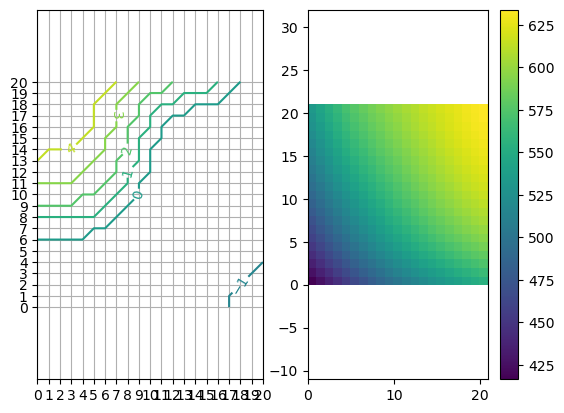

In [3]:
class PolicyIterationSolver(object):

    capacity = 20
    rental_reward = 10.
    moving_cost = 2.
    max_moving = 5

    # bad_action_cost should always non-negative.
    # when bad_action_cost == 0, bad action is not punished, otherwise bad action is published according to value
    # set here.
    # bad_action_cost = 0
    bad_action_cost = 100.

    request_mean_G1 = 3
    request_mean_G2 = 4
    return_mean_G1 = 3
    return_mean_G2 = 2

    discount = 0.9

    PolicyEvaluationError = 0.01

    policy = None
    value = None

    def __init__(self):
        self.policy = np.zeros([self.capacity + 1]*2, int)
        self.value = np.zeros([self.capacity + 1]*2)

        self._reward1 = self.expected_rental_reward(self.request_mean_G1)
        self._reward2 = self.expected_rental_reward(self.request_mean_G2)

        assert self.bad_action_cost >= 0

    def bellman(self, action, s1, s2):
        transp1 = self.transition_probabilty(s1, self.request_mean_G1, self.return_mean_G1, -action)
        transp2 = self.transition_probabilty(s2, self.request_mean_G2, self.return_mean_G2, action)
        transp = np.outer(transp1, transp2)

        return self._reward1[s1] + self._reward2[s2] - self.expected_moving_cost(s1, s2, action) + \
               self.discount * sum((transp * self.value).flat)

    # policy evaluation
    def policy_evaluation(self):
        ''' Keep pocliy fixed and update value. '''
        while True:
            diff = 0.
            it = np.nditer([self.policy], flags=['multi_index'])

            while not it.finished:
                action = it[0]
                s1, s2 = it.multi_index

                _temp = self.value[s1, s2]

                self.value[s1, s2] = self.bellman(action=action, s1=s1, s2=s2)

                diff = max(diff, abs(self.value[s1, s2] - _temp))

                it.iternext()

            print(diff)
            if diff < self.PolicyEvaluationError:
                break

    def policy_update(self):
        is_policy_changed = False

        it = np.nditer([self.policy], flags=['multi_index'])
        while not it.finished:
            s1, s2 = it.multi_index

            _max_val = -1
            _pol = None

            for act in range(-self.max_moving, self.max_moving + 1):
                _val = self.bellman(action=act, s1=s1, s2=s2)
                if _val > _max_val:
                    _max_val = _val
                    _pol = act

            if self.policy[s1, s2] != _pol:
                is_policy_changed = True
                self.policy[s1, s2] = _pol

            it.iternext()

        return is_policy_changed

    def expected_moving_cost(self, s1, s2, action):
        if action == 0:
            return 0.

        # moving from state s1 into state s2
        if action > 0:
            p = self.transition_probabilty(s1, self.request_mean_G1, self.return_mean_G1)
            cost = self._gen_move_cost_array(action)
            return cost.dot(p)

        # moving from state s2 into state s1
        p = self.transition_probabilty(s2, self.request_mean_G2, self.return_mean_G2)
        cost = self._gen_move_cost_array(action)
        return cost.dot(p)

    def _gen_move_cost_array(self, action):
        '''
        Generate an array based on which costs of move is calculated.
        
        If action > available GBikes, then this action is considered as a bad action.
        
        when self.bad_move_cost == 0, bad action is not punished. The system will move max possible GBikes.
        
        When self.bad_move_cost >0, bad action is punished indicated by this variable.
        
        :param action: Number of GBikes that will be moved from station 1 to station 2.
        :return: 
        '''
        _action = abs(action)

        # Don't punish bad action:
        if self.bad_action_cost == 0:
            cost = np.asarray(
                [ii if ii < _action else _action for ii in range(self.capacity+1)]
            ) * self.moving_cost

        # bad action is punished
        else:
            cost = np.asarray(
                [self.bad_action_cost if ii < _action else _action for ii in range(self.capacity + 1)]
            ) * self.moving_cost
        return cost


    @classmethod
    def expected_rental_reward(cls, expected_request):
        return np.asarray([cls._state_reward(s, expected_request) for s in range(cls.capacity + 1)])

    @classmethod
    def _state_reward(cls, s, mu):
        rewards = cls.rental_reward * np.arange(s + 1)
        p = Poisson.pmf_series(mu, cutoff=s)
        return rewards.dot(p)

    def transition_probabilty(self, s, req, ret, action=0):
        '''    
        :param s: Current State
        :param req: Mean value of requests
        :param ret: Mean value of returns
        :param action: Action. Positive means move in. Negative means move out.
        :return: Transition probability.
        '''

        _ret_sz = self.max_moving + self.capacity

        p_req = Poisson.pmf_series(req, s)
        p_ret = Poisson.pmf_series(ret, _ret_sz)
        p = np.outer(p_req, p_ret)

        transp = np.asarray([p.trace(offset) for offset in range(-s, _ret_sz + 1)])

        assert abs(action) <= self.max_moving, "action can be large than %s." % self.max_moving

        # No GBikes are being moved
        if action == 0:
            transp[20] += sum(transp[21:])
            return transp[:21]

        # Move GBikes from station 1 to station 2
        if action > 0:
            transp[self.capacity-action] += sum(transp[self.capacity-action+1:])
            transp[self.capacity-action+1:] = 0

            return np.roll(transp, shift=action)[:self.capacity+1]

        # Move GBikes from station 2 to station 1
        action = -action
        transp[action] += sum(transp[:action])
        transp[:action] = 0

        transp[action+self.capacity] += sum(transp[action+self.capacity+1:])
        transp[action+self.capacity+1:] = 0

        return np.roll(transp, shift=-action)[:self.capacity+1]

    def policy_iteration(self):
        '''
        Caveat: the situation where the policy continually switches between two or more policies that are equally good is not considered yet. 
        :return: 
        '''
        self.policy_evaluation()
        while self.policy_update():
            self.policy_evaluation()




solver = PolicyIterationSolver()

for ii in range(4):
    solver.policy_evaluation()
    solver.policy_update()

print(solver.policy)

import matplotlib.pylab as plt

plt.subplot(121)
CS = plt.contour(solver.policy, levels=range(-6, 6))
plt.clabel(CS)
plt.xlim([0, 20])
plt.ylim([0, 20])
plt.axis('equal')
plt.xticks(range(21))
plt.yticks(range(21))
plt.grid('on')

plt.subplot(122)
plt.pcolor(solver.value)
plt.colorbar()
plt.axis('equal')

plt.show()

In this code, we first define the problem parameters, including the maximum number of bikes at each location, the maximum number of bikes to move between locations, the reward for renting out a bike, the cost of moving a bike between locations, the additional parking cost for parking more than 10 bikes, and the discount factor.

We then initialize the value function to zero and run the value iteration algorithm until convergence, which is determined by a specified tolerance threshold.

For each (i,j) state and all possible actions, the code calculates the corresponding Q value using the modified reward function that includes the additional parking cost and the employee's free bike movement. It then selects the action with

193.34904927512352
134.00426086449983
90.45243773749041
67.59779106615537
53.584930617584064
41.72086291128721
32.72010939685788
26.087556138178115
21.778143392699917
18.31805979033311
15.367406347701888
12.861027123616623
10.739286690815788
8.949004145272568
7.44312843375684
6.180206266078585
5.123897292162269
4.242540347244926
3.5087368683560953
2.898934555425967
2.393012044082809
1.973873579670851
1.6270638320038415
1.3404108007533182
1.103701663738775
0.9083935811099764
0.747359290960901
0.6146658513105194
0.5053839897122998
0.4154250710594738
0.3414025532428582
0.2805148621151261
0.23044680201468282
0.18928686930178173
0.1554581156260042
0.12766049026453175
0.1048228615680955
0.08606316780407042
0.07065537333363636
0.05800210589370636
0.04761202529914499
0.039081124728909344
0.032077295015767504
0.02632759237303617
0.021607743132449286
0.017733497475205695
0.014553510055350216
0.01194348042730553
0.009801332242659555
53.517394645897014
6.1734677086436704
3.1669552535424828
2.45798

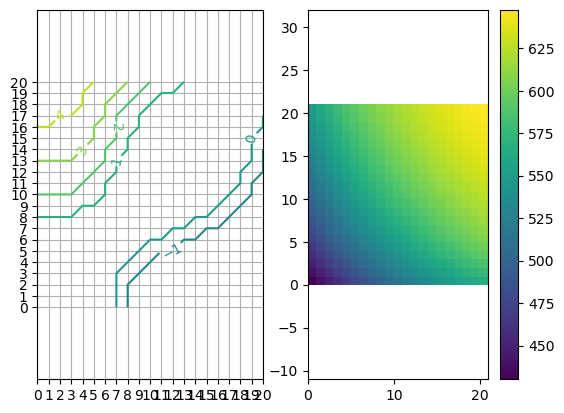

In [4]:
class PolicyIterationSolver(object):

    capacity = 20
    rental_reward = 10.
    moving_cost = 2.
    max_moving = 5
    parking_cost = 4.

    # bad_action_cost should always non-negative.
    # when bad_action_cost == 0, bad action is not punished, otherwise bad action is published according to value
    # set here.
    # bad_action_cost = 0
    bad_action_cost = 100.

    request_mean_G1 = 3
    request_mean_G2 = 4
    return_mean_G1 = 3
    return_mean_G2 = 2

    discount = 0.9

    PolicyEvaluationError = 0.01

    policy = None
    value = None

    def __init__(self):
        self.policy = np.zeros([self.capacity + 1]*2, int)
        self.value = np.zeros([self.capacity + 1]*2)

        self._reward1 = self.expected_rental_reward(self.request_mean_G1)
        self._reward2 = self.expected_rental_reward(self.request_mean_G2)

        assert self.bad_action_cost >= 0

    def bellman(self, action, s1, s2):
        transp1 = self.transition_probabilty(s1, self.request_mean_G1, self.return_mean_G1, -action)
        transp2 = self.transition_probabilty(s2, self.request_mean_G2, self.return_mean_G2, action)
        transp = np.outer(transp1, transp2)

        return self._reward1[s1] + self._reward2[s2] - self.expected_moving_cost(s1, s2, action) + \
               self.discount * sum((transp * self.value).flat)

    # policy evaluation
    def policy_evaluation(self):
        ''' Keep pocliy fixed and update value. '''
        while True:
            diff = 0.
            it = np.nditer([self.policy], flags=['multi_index'])

            while not it.finished:
                action = it[0]
                s1, s2 = it.multi_index

                _temp = self.value[s1, s2]

                self.value[s1, s2] = self.bellman(action=action, s1=s1, s2=s2)

                diff = max(diff, abs(self.value[s1, s2] - _temp))

                it.iternext()

            print(diff)
            if diff < self.PolicyEvaluationError:
                break

    def policy_update(self):
        is_policy_changed = False

        it = np.nditer([self.policy], flags=['multi_index'])
        while not it.finished:
            s1, s2 = it.multi_index

            _max_val = -1
            _pol = None

            for act in range(-self.max_moving, self.max_moving + 1):
                _val = self.bellman(action=act, s1=s1, s2=s2)
                if _val > _max_val:
                    _max_val = _val
                    _pol = act

            if self.policy[s1, s2] != _pol:
                is_policy_changed = True
                self.policy[s1, s2] = _pol

            it.iternext()

        return is_policy_changed

    def expected_moving_cost(self, s1, s2, action):
        if action == 0:
            return 0.

        # moving from state s1 into state s2
        if action > 0:
            p = self.transition_probabilty(s1, self.request_mean_G1, self.return_mean_G1)
            cost = self._gen_move_cost_array(action)
            if action > 10:
              cost += self.parking_cost * (action - 10)
            return cost.dot(p)

        # moving from state s2 into state s1
        p = self.transition_probabilty(s2, self.request_mean_G2, self.return_mean_G2)
        cost = self._gen_move_cost_array(action)
        if action > 10:
            cost += self.parking_cost * (action - 10)
        return cost.dot(p)

    def _gen_move_cost_array(self, action):
        '''
        Generate an array based on which costs of move is calculated.
        
        If action > available GBikes, then this action is considered as a bad action.
        
        when self.bad_move_cost == 0, bad action is not punished. The system will move max possible GBikes.
        
        When self.bad_move_cost >0, bad action is punished indicated by this variable.
        
        :param action: Number of GBikes that will be moved from station 1 to station 2.
        :return: 
        '''
        _action = abs(action)

        if _action != 0:
          _action -= 1

        # Don't punish bad action:
        if self.bad_action_cost == 0:
            cost = np.asarray(
                [ii if ii < _action else _action for ii in range(self.capacity+1)]
            ) * self.moving_cost

        # bad action is punished
        else:
            cost = np.asarray(
                [self.bad_action_cost if ii < _action else _action for ii in range(self.capacity + 1)]
            ) * self.moving_cost
        return cost


    @classmethod
    def expected_rental_reward(cls, expected_request):
        return np.asarray([cls._state_reward(s, expected_request) for s in range(cls.capacity + 1)])

    @classmethod
    def _state_reward(cls, s, mu):
        rewards = cls.rental_reward * np.arange(s + 1)
        p = Poisson.pmf_series(mu, cutoff=s)
        return rewards.dot(p)

    def transition_probabilty(self, s, req, ret, action=0):
        '''    
        :param s: Current State
        :param req: Mean value of requests
        :param ret: Mean value of returns
        :param action: Action. Positive means move in. Negative means move out.
        :return: Transition probability.
        '''

        _ret_sz = self.max_moving + self.capacity

        p_req = Poisson.pmf_series(req, s)
        p_ret = Poisson.pmf_series(ret, _ret_sz)
        p = np.outer(p_req, p_ret)

        transp = np.asarray([p.trace(offset) for offset in range(-s, _ret_sz + 1)])

        assert abs(action) <= self.max_moving, "action can be large than %s." % self.max_moving

        # No GBikes are being moved
        if action == 0:
            transp[20] += sum(transp[21:])
            return transp[:21]

        # Move GBikes from station 1 to station 2
        if action > 0:
            transp[self.capacity-action] += sum(transp[self.capacity-action+1:])
            transp[self.capacity-action+1:] = 0

            return np.roll(transp, shift=action)[:self.capacity+1]

        # Move GBikes from station 2 to station 1
        action = -action
        transp[action] += sum(transp[:action])
        transp[:action] = 0

        transp[action+self.capacity] += sum(transp[action+self.capacity+1:])
        transp[action+self.capacity+1:] = 0

        return np.roll(transp, shift=-action)[:self.capacity+1]

    def policy_iteration(self):
        '''
        Caveat: the situation where the policy continually switches between two or more policies that are equally good is not considered yet. 
        :return: 
        '''
        self.policy_evaluation()
        while self.policy_update():
            self.policy_evaluation()




solver = PolicyIterationSolver()

for ii in range(4):
    solver.policy_evaluation()
    solver.policy_update()

print(solver.policy)

import matplotlib.pylab as plt

plt.subplot(121)
CS = plt.contour(solver.policy, levels=range(-6, 6))
plt.clabel(CS)
plt.xlim([0, 20])
plt.ylim([0, 20])
plt.axis('equal')
plt.xticks(range(21))
plt.yticks(range(21))
plt.grid('on')

plt.subplot(122)
plt.pcolor(solver.value)
plt.colorbar()
plt.axis('equal')

plt.show()